In [10]:
import scanpy as sc
import anndata
import os
import fnmatch
%matplotlib inline
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
#import scrublet as scr
import importlib
import sys
from harmony import harmonize
import seaborn as sns
from matplotlib import rcParams
import math
from scipy import stats
import seaborn as sns
import scipy as sp
import h5py
import warnings
import random
import math
import scvelo as scv
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

NOTE: Significant amounts of this code have been adopted from Kotliar et al, Cell 2020 - namely running MAST on a scanpy adata object. Please cite the orignial authors if using Dylan's MAST code.

In [2]:
adata_allcells = sc.read_h5ad("./adata_Final_for_Reinfection_publication.h5ad")
adata_allcells

AnnData object with n_obs × n_vars = 88360 × 25901
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering'
    var: 'n_cells', 'Blacklist_Genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    var

In [3]:
adata = sc.AnnData(adata_allcells.raw.X, obs=adata_allcells.obs, var=adata_allcells.raw.var, uns=adata_allcells.uns)
adata = adata[adata.obs['CoarseClustering'].isin(['T,NK cells']), :]
adata

View of AnnData object with n_obs × n_vars = 44669 × 26030
    obs: 'sample', 'DGE_name', 'monkey', 'array number', 'Sample Name', 'Sample type', 'Time point of sampling', 'Infusion before 2nd Mtb infection anti CD4 or IgG', 'Naïve or Primary Infection or Reinfection at sample time', 'Group', 'Group_Detailed', 'Drug Treatment', 'CFU Total ', 'Type of Mtb strain ', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'percent_hbb', 'predicted_doublets', 'color', 'SubclusteringGroup', 'Subclustering', 'Doublet', 'leiden', 'leiden_lab_orig', 'Doublet_labels', 'Doublet_colors', 'Doublet_str', 'Doublet_int', 'CoarseClustering'
    var: 'n_cells', 'Blacklist_Genes'
    uns: 'CoarseClustering_colors', 'Doublet_colors_colors', 'Doublet_str_colors', 'Group_colors', 'Subclustering_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_lab_orig_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'

In [11]:
import os
adir = './MAST_DE_TNK_Outputs'
project_name = 'File_NEW'
gcs = False
abase = os.path.join(adir, project_name)
results_dir = './MAST_DE_TNK_Outputs/results'

In [12]:
dedir = os.path.join(adir, 'DE_Stage')
if not os.path.exists(dedir): os.mkdir(dedir)
    
de_infiles = os.path.join(dedir, 'genefiles')
if not os.path.exists(de_infiles): os.mkdir(de_infiles)
    
de_results = os.path.join(dedir, 'results')
if not os.path.exists(de_results): os.mkdir(de_results)

In [13]:
import palettable
from IPython.display import display
from joblib import parallel_backend
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from matplotlib import gridspec

In [ ]:
adata_raw=adata
set(list(adata.obs.Subclustering))

In [67]:
labmap = {
'$T_{EMRA-like}$':"Temralike",
 '$T_{Eff-like}$':"Tefflike",
 '$T_{M-like}$':"Tmlike",
 '$T_{Naive/CM-like}$':"Tnaivecmlike",
 'FURIN$^{hi}$ $T_{M-like}$':"FurinTmlike",
 'GZMK$^{hi}$ $T_{EM/PEX-like}$':"Tempexlike",
 'ILC-like':"ILClike",
 'NK-like':"NKlike",
 'T1T17-like':"T1T17like",
 'Tc17-like':"Tc17like",
 'Tregs':"Tregs"}
       
adata_raw.obs['Detailed_Subclustering_Tcells'] = adata_raw.obs['Subclustering'].replace(labmap)


In [68]:
list(set(adata_raw.obs['Detailed_Subclustering_Tcells'] ))

['Tefflike',
 'NKlike',
 'Tc17like',
 'Tnaivecmlike',
 'Tempexlike',
 'Temralike',
 'Tregs',
 'ILClike',
 'FurinTmlike',
 'Tmlike',
 'T1T17like']

Start use of Kotliar et al. Cell 2020 MAST code

In [69]:
#adata_raw=adata_12
adata_raw.raw = adata_raw.copy()

In [70]:
cts = ['Tefflike',
 'NKlike',
 'Tc17like',
 'Tnaivecmlike',
"FurinTmlike",
 'Tempexlike',
 'Temralike',
 'Tregs',
 'ILClike',
 'Tmlike',
 'T1T17like']
test_periods = ["IgG", "Naïve", "antiCD4"]

for ct in cts:
    for test_period in test_periods:
        ind = (adata_raw.obs['Detailed_Subclustering_Tcells']==ct) & (adata_raw.obs['Group_Detailed'].isin(['IgG', test_period]))
        adata_ct = adata_raw[ind,:].copy()
        adata_ct.obs['Group_Detailed_Binary'] = adata_ct.obs['Group_Detailed'].replace({'IgG':0, test_period:1})        
        #adata_ct.obs['is_fresh_scale'] = scale(adata_ct.obs['is_fresh'])
        adata_ct.obs['percent_mito_scale'] = scale(adata_ct.obs['percent_mito'])
        sc.pp.filter_genes(adata_ct, min_cells=(.01*adata_ct.shape[0]))
        adata_ct.obs['cngeneson'] =  scale(np.asarray((adata_ct.X>0).sum(axis=1)).reshape(-1))       
        sc.pp.normalize_per_cell(adata_ct, counts_per_cell_after=10000)
        sc.pp.log1p(adata_ct)
        X = pd.DataFrame(adata_ct.X.todense(), index=adata_ct.obs.index, columns=adata_ct.var.index).T
        X.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv'))
        adata_ct.obs.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv'))
        adata_ct.var.to_csv(os.path.join(de_infiles, ct+'.'+test_period+'.genedata.csv'))

In [72]:
ncores =4
testvar = 'Group_Detailed_Binary'
covars = ['cngeneson', 'percent_mito_scale']
covarstr = ','.join(covars)

for ct in cts:
    for test_period in test_periods:
        exprfn = os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv')
        celldatfn = os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv')
        genedatfn = os.path.join(de_infiles, ct+'.'+test_period+'.genedata.csv')
        resultsfn = os.path.join(de_results, ct+'.'+test_period+'.DE.csv')
        cmd = 'Rscript ./run_mast.R %s %s %s %s %d %s %s' % (exprfn, celldatfn, genedatfn, resultsfn, ncores, testvar, covarstr)
        print(cmd)
        !{cmd}

Rscript /Users/joshuadavidbromley/Desktop/run_mast.R /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/Tefflike.IgG.expression.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/Tefflike.IgG.celldata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/Tefflike.IgG.genedata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/results/Tefflike.IgG.DE.csv 4 Group_Detailed_Binary cngeneson,percent_mito_scale
~Group_Detailed_Binary + cngeneson + percent_mito_scale
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et is log-transformed.
 Completed [==========>------------------------------

~Group_Detailed_Binary + cngeneson + percent_mito_scale
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et is log-transformed.
 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Rscript /Users/joshuadavidbromley/Desktop/run_mast.R /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/Tnaivecmlike.antiCD4.expression.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/Tnaivecmlike.antiCD4.celldata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_she

 Completed [==========>---------------------------------]  25% with 0 failures Completed [--------------------------------------------]   1% with 0 failures
Done!
Warning message:
In .nextMethod(object = object, value = value) :
  Coefficients Group_Detailed_Binary are never estimible and will be dropped.
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Error in generateHypothesis(hypothesis, colnames(object@coefD)) : 
  Term(s) 'Group_Detailed_Binary ,' not found.
Terms available: (Intercept) , cngeneson , percent_mito_scale , 
Calls: summary ... lapply -> FUN -> lrTest -> lrTest -> generateHypothesis
Execution halted
Rscript /Users/joshuadavidbromley/Desktop/run_mast.R /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/Tempexlike.Naïve.expression.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_T

 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Refitting on reduced model...
 Completed [==========>---------------------------------]  25% with 0 failures
Done!
Rscript /Users/joshuadavidbromley/Desktop/run_mast.R /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/ILClike.antiCD4.expression.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/ILClike.antiCD4.celldata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/ILClike.antiCD4.genedata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/results/ILClike.antiCD4.DE.csv 4 Group_De

Rscript /Users/joshuadavidbromley/Desktop/run_mast.R /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/T1T17like.Naïve.expression.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/T1T17like.Naïve.celldata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/genefiles/T1T17like.Naïve.genedata.csv /Users/joshuadavidbromley/Desktop/Reinfection_Figures_For_Publication/Figure4/Excel_sheets/MAST_DE_TNK_Outputs/DE_Stage/results/T1T17like.Naïve.DE.csv 4 Group_Detailed_Binary cngeneson,percent_mito_scale
~Group_Detailed_Binary + cngeneson + percent_mito_scale
`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name et is log-transformed.
 Completed [==========>------------------

In [81]:
allres = []
cts = ['Tefflike',
 'NKlike',
 'Tc17like',
 'Tnaivecmlike',
"FurinTmlike",
 'Tempexlike',
 'Temralike',
 'Tregs',
 'ILClike',
 'Tmlike',
 'T1T17like']
test_periods = ["Naïve", "antiCD4"]
for ct in cts:
    for test_period in test_periods:
        resultsfn = os.path.join(de_results, ct+'.'+test_period+'.DE.csv')
        res = pd.read_csv(resultsfn)
        res.index = res['primerid']
        res['logP'] = res['P_H'].apply(np.log10)*-1
        (_,q,_,_) = multipletests(res['P_H'].dropna(), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
        res['Q'] = np.nan
        res.loc[~res['P_H'].isnull(), 'Q'] = q
        res['logQ'] = res['Q'].apply(np.log10)*-1
        res = res[['logFC', 'P_H', 'logP', 'Q', 'logQ']]
        expr = pd.read_csv(os.path.join(de_infiles, ct+'.'+test_period+'.expression.csv'), index_col=0)
        obs = pd.read_csv(os.path.join(de_infiles, ct+'.'+test_period+'.celldata.csv'), index_col=0)
        logFC2 = expr.loc[:,obs['Group_Detailed']==test_period].mean(axis=1)-expr.loc[:,obs['Group_Detailed']!=test_period].mean(axis=1)
        res['logFC_unadjusted'] = logFC2
        res['logFC_combined'] = res['logFC'].copy()
        ind = res['logFC'].isnull()
        res.loc[ind, 'logFC_combined'] = res.loc[ind, 'logFC_unadjusted']        
        res.columns = [(ct, test_period, x) for x in res.columns]
        allres.append(res)
        
allres = pd.concat(allres, axis=1)
allres.columns = pd.MultiIndex.from_tuples(allres.columns)


In [82]:
allres.head()


Tefflike                                                           \
             Naïve                                                            
             logFC       P_H      logP         Q      logQ logFC_unadjusted   
primerid                                                                      
AAAS     -0.005790  0.957727  0.018758  0.999252  0.000325         0.014982   
AACS     -0.208327  0.134180  0.872312  0.895563  0.047904        -0.200663   
AAED1    -0.066893  0.726809  0.138580  0.999252  0.000325        -0.069133   
AAGAB     0.037467  0.843899  0.073709  0.999252  0.000325         0.056537   
AAK1     -0.091641  0.496038  0.304485  0.970535  0.012989        -0.068300   

                                                       ... T1T17like  \
                          antiCD4                      ...     Naïve   
         logFC_combined     logFC       P_H      logP  ...      logQ   
primerid                                               ...             
AAAS          -0.005790 -0.011901  0.944190  0.024940  ...  0.277942   
AACS          -0.208327 -0.160790  0.298162  0.525548  ...  0.075739   
AAED1         -0.066893 -0.093056  0.405168  0.392365  ...  0.105953   
AAGAB          0.037467  0.006392  0.993035  0.003035  ...  0.059934   
AAK1          -0.091641 -0.094673  0.455668  0.341352  ...  1.009743   

                                                                        \
                                           antiCD4                       
         logFC_unadjusted logFC_combined     logFC       P_H      logP   
primerid                                                                 
AAAS             0.016323       0.024461  0.002323  0.721350  0.141854   
AACS            -0.037341      -0.035279 -0.090483  0.026676  1.573877   
AAED1            0.003766       0.024028 -0.036131  0.109595  0.960209   
AAGAB           -0.015153      -0.009815 -0.017309  0.690630  0.160755   
AAK1            -0.056107      -0.078467 -0.064254  0.062039  1.207337   

                                                              
                                                              
                 Q      logQ logFC_unadjusted logFC_combined  
primerid                                                      
AAAS      0.902040  0.044774         0.002252       0.002323  
AACS      0.134593  0.870977        -0.074153      -0.090483  
AAED1     0.336777  0.472658        -0.040486      -0.036131  
AAGAB     0.886263  0.052437        -0.013313      -0.017309  
AAK1      0.238033  0.623362        -0.051349      -0.064254  

[5 rows x 154 columns]

In [75]:
mergefn = os.path.join(de_results, 'AllCT.AllPeriod.DE.Merged.csv')
allres.to_csv(mergefn)


In [14]:
mergefn = os.path.join(de_results, 'AllCT.AllPeriod.DE.Merged.csv')
allres = pd.read_csv(mergefn, header=[0,1,2], index_col=0)
allres.head()


Tefflike                                                           \
             Naïve                                                            
             logFC       P_H      logP         Q      logQ logFC_unadjusted   
primerid                                                                      
AAAS     -0.005790  0.957727  0.018758  0.999252  0.000325         0.014982   
AACS     -0.208327  0.134180  0.872312  0.895563  0.047904        -0.200663   
AAED1    -0.066893  0.726809  0.138580  0.999252  0.000325        -0.069133   
AAGAB     0.037467  0.843899  0.073709  0.999252  0.000325         0.056537   
AAK1     -0.091641  0.496038  0.304485  0.970535  0.012989        -0.068300   

                                                       ... T1T17like  \
                          antiCD4                      ...     Naïve   
         logFC_combined     logFC       P_H      logP  ...      logQ   
primerid                                               ...             
AAAS          -0.005790 -0.011901  0.944190  0.024940  ...  0.277942   
AACS          -0.208327 -0.160790  0.298162  0.525548  ...  0.075739   
AAED1         -0.066893 -0.093056  0.405168  0.392365  ...  0.105953   
AAGAB          0.037467  0.006392  0.993035  0.003035  ...  0.059934   
AAK1          -0.091641 -0.094673  0.455668  0.341352  ...  1.009743   

                                                                        \
                                           antiCD4                       
         logFC_unadjusted logFC_combined     logFC       P_H      logP   
primerid                                                                 
AAAS             0.016323       0.024461  0.002323  0.721350  0.141854   
AACS            -0.037341      -0.035279 -0.090483  0.026676  1.573877   
AAED1            0.003766       0.024028 -0.036131  0.109595  0.960209   
AAGAB           -0.015153      -0.009815 -0.017309  0.690630  0.160755   
AAK1            -0.056107      -0.078467 -0.064254  0.062039  1.207337   

                                                              
                                                              
                 Q      logQ logFC_unadjusted logFC_combined  
primerid                                                      
AAAS      0.902040  0.044774         0.002252       0.002323  
AACS      0.134593  0.870977        -0.074153      -0.090483  
AAED1     0.336777  0.472658        -0.040486      -0.036131  
AAGAB     0.886263  0.052437        -0.013313      -0.017309  
AAK1      0.238033  0.623362        -0.051349      -0.064254  

[5 rows x 154 columns]

In [9]:
allres["Tempexlike"]["Naïve"]["logFC"]

primerid
AAAS      0.009678
AACS     -0.054692
AAED1    -0.055671
AAGAB    -0.010569
AAK1     -0.042509
            ...   
MYLPF          NaN
PRSS23         NaN
RET            NaN
TEAD1          NaN
TIGD3          NaN
Name: logFC, Length: 13123, dtype: float64

In [9]:
allres

Tefflike                                                           \
             Naïve                                                            
             logFC       P_H      logP         Q      logQ logFC_unadjusted   
primerid                                                                      
AAAS     -0.005790  0.957727  0.018758  0.999252  0.000325         0.014982   
AACS     -0.208327  0.134180  0.872312  0.895563  0.047904        -0.200663   
AAED1    -0.066893  0.726809  0.138580  0.999252  0.000325        -0.069133   
AAGAB     0.037467  0.843899  0.073709  0.999252  0.000325         0.056537   
AAK1     -0.091641  0.496038  0.304485  0.970535  0.012989        -0.068300   
...            ...       ...       ...       ...       ...              ...   
MYLPF          NaN       NaN       NaN       NaN       NaN              NaN   
PRSS23         NaN       NaN       NaN       NaN       NaN              NaN   
RET            NaN       NaN       NaN       NaN       NaN              NaN   
TEAD1          NaN       NaN       NaN       NaN       NaN              NaN   
TIGD3          NaN       NaN       NaN       NaN       NaN              NaN   

                                                       ... T1T17like  \
                          antiCD4                      ...     Naïve   
         logFC_combined     logFC       P_H      logP  ...      logQ   
primerid                                               ...             
AAAS          -0.005790 -0.011901  0.944190  0.024940  ...  0.277942   
AACS          -0.208327 -0.160790  0.298162  0.525548  ...  0.075739   
AAED1         -0.066893 -0.093056  0.405168  0.392365  ...  0.105953   
AAGAB          0.037467  0.006392  0.993035  0.003035  ...  0.059934   
AAK1          -0.091641 -0.094673  0.455668  0.341352  ...  1.009743   
...                 ...       ...       ...       ...  ...       ...   
MYLPF               NaN       NaN       NaN       NaN  ...       NaN   
PRSS23              NaN       NaN       NaN       NaN  ...       NaN   
RET                 NaN       NaN       NaN       NaN  ...       NaN   
TEAD1               NaN       NaN       NaN       NaN  ...       NaN   
TIGD3               NaN       NaN       NaN       NaN  ...       NaN   

                                                                        \
                                           antiCD4                       
         logFC_unadjusted logFC_combined     logFC       P_H      logP   
primerid                                                                 
AAAS             0.016323       0.024461  0.002323  0.721350  0.141854   
AACS            -0.037341      -0.035279 -0.090483  0.026676  1.573877   
AAED1            0.003766       0.024028 -0.036131  0.109595  0.960209   
AAGAB           -0.015153      -0.009815 -0.017309  0.690630  0.160755   
AAK1            -0.056107      -0.078467 -0.064254  0.062039  1.207337   
...                   ...            ...       ...       ...       ...   
MYLPF                 NaN            NaN  0.000832  0.612176  0.213124   
PRSS23                NaN            NaN  0.005452  0.322718  0.491177   
RET                   NaN            NaN -0.007627  0.718957  0.143297   
TEAD1                 NaN            NaN  0.006473  0.395406  0.402957   
TIGD3                 NaN            NaN -0.006024  0.511568  0.291097   

                                                              
                                                              
                 Q      logQ logFC_unadjusted logFC_combined  
primerid                                                      
AAAS      0.902040  0.044774         0.002252       0.002323  
AACS      0.134593  0.870977        -0.074153      -0.090483  
AAED1     0.336777  0.472658        -0.040486      -0.036131  
AAGAB     0.886263  0.052437        -0.013313      -0.017309  
AAK1      0.238033  0.623362        -0.051349      -0.064254  
...            ...       ...              ...            ...  
MY

In [10]:
allres = allres.reindex(columns=['Tefflike',
 'NKlike',
 'Tc17like',
 'Tnaivecmlike',
"FurinTmlike",
 'Tempexlike',
 'Temralike',
 'Tregs',
 'ILClike',
 'Tmlike',
 'T1T17like'], level=0)


In [17]:
q_thresh = 0.05
FC_thresh = 1.3
log_FC_thresh = np.log(FC_thresh)

In [18]:
q_thresh = 0.05
FC_thresh = 1.3
log_FC_thresh = np.log(FC_thresh)
allres_P = allres.xs('P_H', axis=1, level=2)
allres_Q = allres.xs('Q', axis=1, level=2)
allres_FC = allres.xs('logFC', axis=1, level=2)

In [19]:
issig = (allres_Q<q_thresh) &  (allres_FC.abs() > log_FC_thresh)
issig.sum(axis=0)

Tefflike      Naïve       31
              antiCD4     13
NKlike        Naïve      150
              antiCD4    127
Tc17like      Naïve      220
              antiCD4    135
Tnaivecmlike  Naïve       88
              antiCD4     79
FurinTmlike   Naïve      214
              antiCD4    175
Tempexlike    Naïve      119
              antiCD4    119
Temralike     Naïve      136
              antiCD4    106
Tregs         Naïve      131
              antiCD4    122
ILClike       Naïve       60
              antiCD4     66
Tmlike        Naïve      109
              antiCD4    131
T1T17like     Naïve      274
              antiCD4    190
dtype: int64

END implementation of Kotliar et al MAST 

In [ ]:
cell_types_to_plot = [
 'Tmlike',
 'Tregs',
 'T1T17like',
"FurinTmlike",
 'Tnaivecmlike'
]
cell_types_to_plot = [
     'Temralike',
     'Tempexlike',
      'Tefflike',
     'Tc17like',
     'NKlike',
     'ILClike',
]

In [27]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# cell types order
cell_types_to_plot = cell_types_to_plot = [
 'Tmlike',
 'Tregs',
 'T1T17like',
"FurinTmlike",
 'Tnaivecmlike'
]

def plot_group(data, issig_data, group_name, genes_of_interest, save=None, flip_direction=False):
    display_data = data.loc[genes_of_interest].xs(group_name, axis=1, level=1)
    issig_display = issig_data.loc[genes_of_interest].xs(group_name, axis=1, level=1)
    '''
    - data input: MAST allres_FC
    
    - issig_data must be calculated before running
    
    - to make the data more biologically interpretable/easy to read the figure since everything is 
      WRT to IgG we can transform the data by multiplying by -1 (these are the MAST allres_FC data
        - the non-"flipped" data can also be plotted, if desired. use "flip_direction" do define
    '''
    if flip_direction:
        display_data = display_data * -1
    
    cmap = 'RdBu_r'
    cell_type_colors = {cell_type: f"C{i}" for i, cell_type in enumerate(cell_types_to_plot)}
    fig, ax = plt.subplots(figsize=(3.75, 16))
    display_data = display_data[cell_types_to_plot]
    issig_display = issig_display[cell_types_to_plot]
    sns.heatmap(display_data, ax=ax, cmap=cmap, vmin=-0.5, vmax=0.5, cbar_kws={'label': 'log$_{e}$FC'})
    ax.set_xticks(np.arange(display_data.shape[1]) + 0.5)
    ax.set_xticklabels(display_data.columns, rotation=90, ha='center', fontsize=16)
    ax.set_yticklabels(display_data.index, rotation=0, fontsize=15, fontstyle='italic')
    ax.tick_params(axis='both', which='both', length=0)
    for xtick in ax.get_xticklabels():
        label_text = xtick.get_text()  
        color = cell_type_colors.get(label_text, 'black')  
        xtick.set_color(color)
    threshold_value = log_FC_thresh
    for x in range(display_data.shape[1]):
        for y in range(display_data.shape[0]):
            if abs(display_data.iloc[y, x]) > threshold_value:
                ax.plot(x + 0.5, y + 0.5, 'o', ms=5, mec='none', mfc='white')
    for x in range(display_data.shape[1]):
        for y in range(display_data.shape[0]):
            col = display_data.columns[x]
            row = display_data.index[y]
            if issig_display.at[row, col]:
                ax.add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='black', lw=2))
                
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_edgecolor('black')
    if flip_direction:
        plt.title(f"{group_name}")
        ax.set_ylabel("log$_{e}$FC")
    else:
        plt.title(f"{group_name}")
        ax.set_ylabel("log$_{e}$FC")
    
    if save:
        plt.savefig(save, dpi=1000, bbox_inches='tight')
    else:
        plt.show()


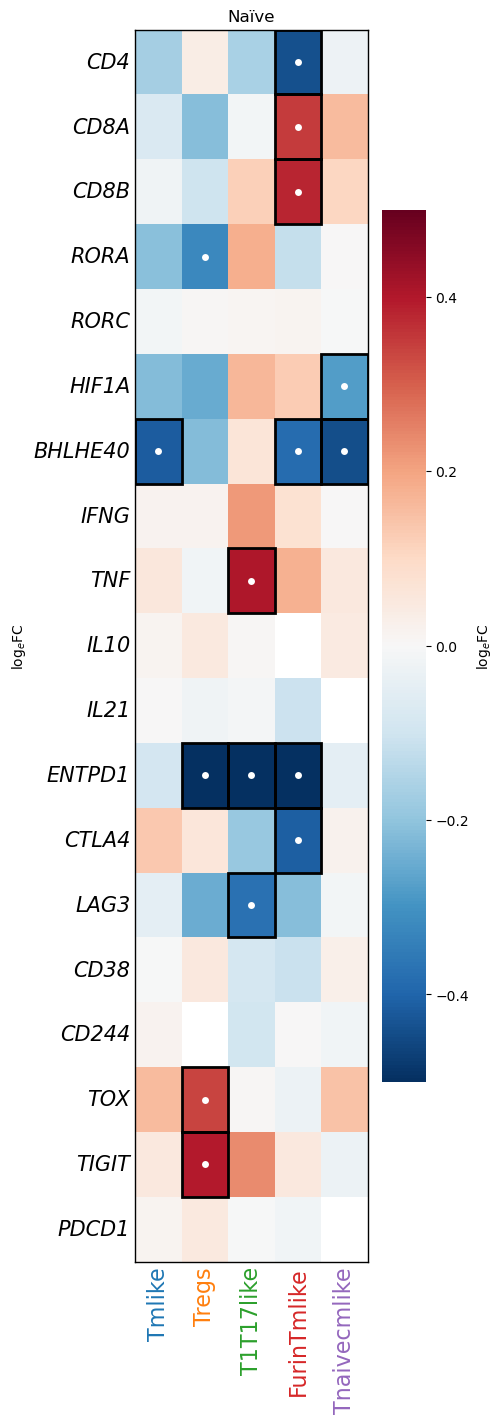

In [28]:
# naive CD4 TNK cell plot
show_genes = ["CD4", "CD8A", "CD8B","RORA", "RORC", "HIF1A", "BHLHE40", "IFNG", "TNF", "IL10", "IL21", "ENTPD1",
              "CTLA4", "LAG3", "CD38", "CD244", "TOX", "TIGIT", "PDCD1"]

plot_group(allres_FC, issig, "Naïve", show_genes,save=None,flip_direction=True)


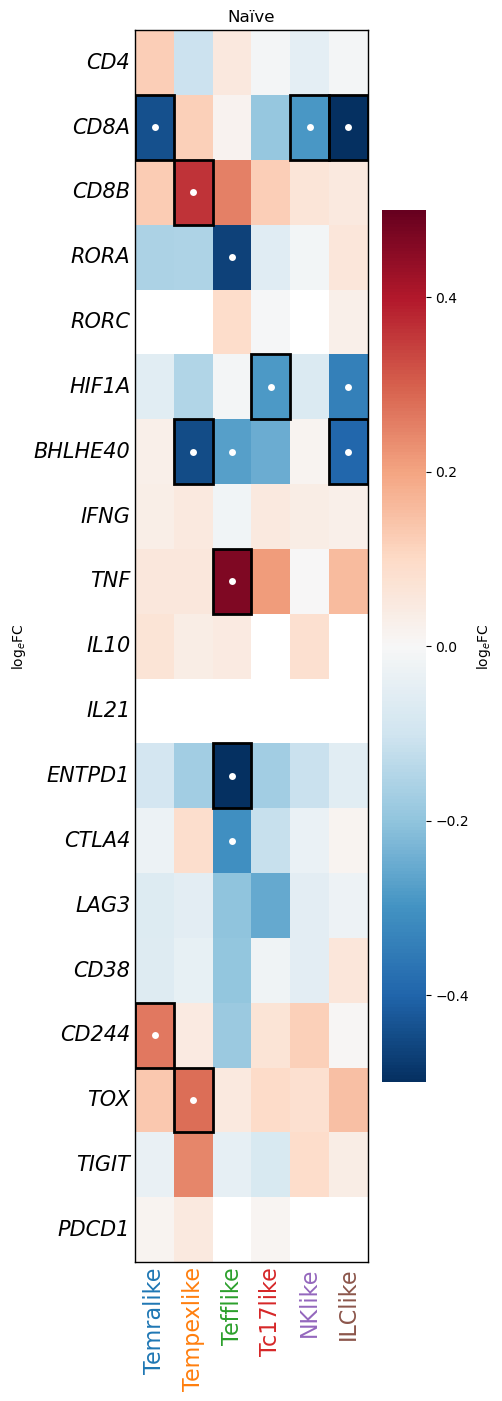

In [22]:
# naive CD8 TNK cell plot
show_genes = ["CD4", "CD8A", "CD8B","RORA", "RORC", "HIF1A", "BHLHE40", "IFNG", "TNF", "IL10", "IL21", "ENTPD1",
              "CTLA4", "LAG3", "CD38", "CD244", "TOX", "TIGIT", "PDCD1"]

plot_group(allres_FC, issig, "Naïve", show_genes,save=None,flip_direction=True)

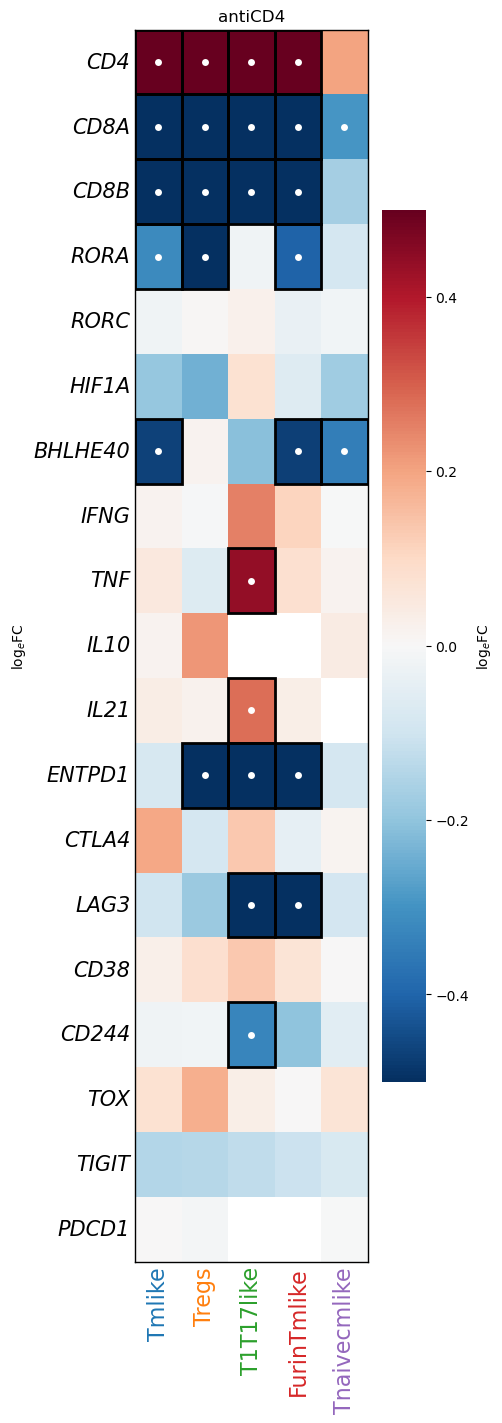

In [29]:
# anticd4 CD4 TNK cell plot
#note the IgG vs Naive are hard coded and will need to be changed for each plot (should be IgG vs aCD4)
show_genes = ["CD4", "CD8A", "CD8B","RORA", "RORC", "HIF1A", "BHLHE40", "IFNG", "TNF", "IL10", "IL21", "ENTPD1",
              "CTLA4", "LAG3", "CD38", "CD244", "TOX", "TIGIT", "PDCD1"]

plot_group(allres_FC, issig, "antiCD4", show_genes,save=None,flip_direction=True)


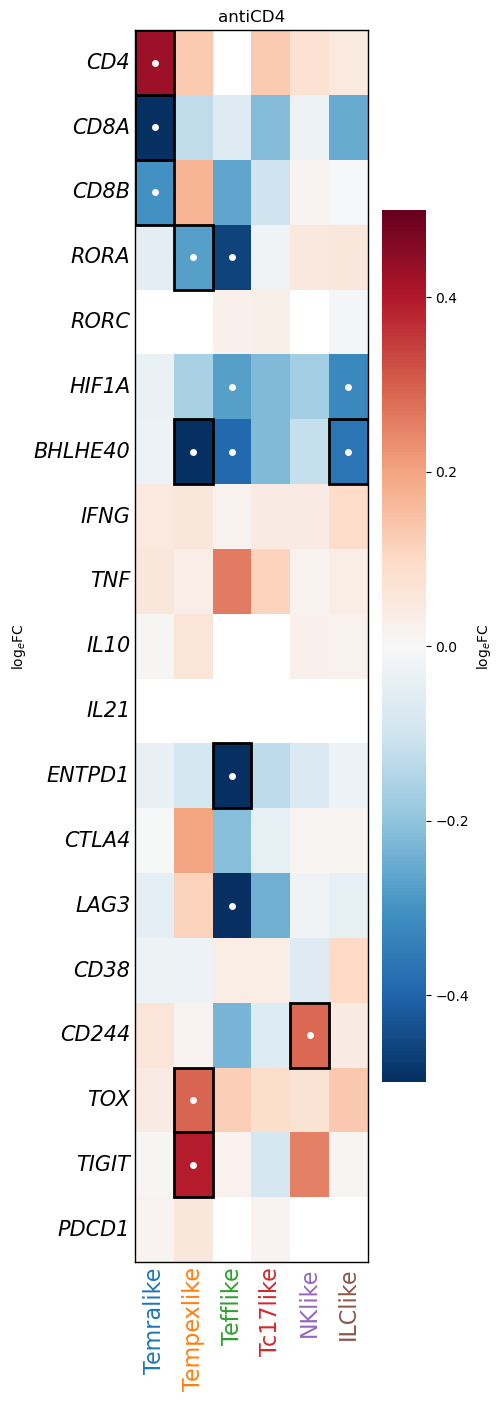

In [23]:
# antiCD4 CD8+ TNK cell plot
show_genes = ["CD4", "CD8A", "CD8B","RORA", "RORC", "HIF1A", "BHLHE40", "IFNG", "TNF", "IL10", "IL21", "ENTPD1",
              "CTLA4", "LAG3", "CD38", "CD244", "TOX", "TIGIT", "PDCD1"]
plot_group(allres_FC, issig, "antiCD4", show_genes,save=None,flip_direction=True)


# Heatmaps for supplemental figure

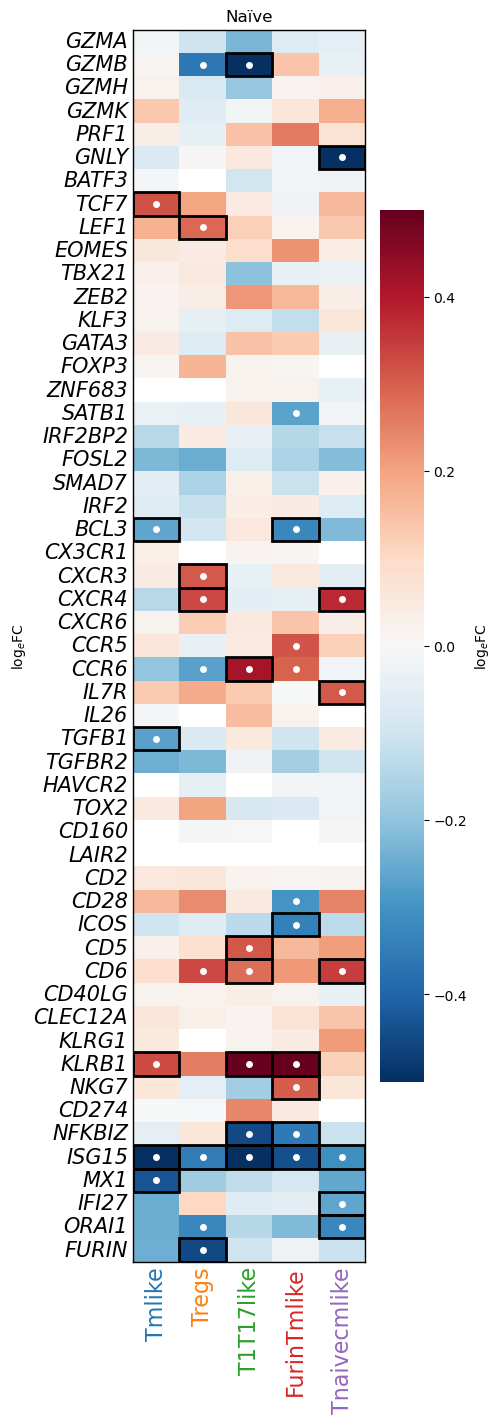

In [30]:
# naive CD4 Supp Fig TNK cell plot
show_genes = [
"GZMA", "GZMB", "GZMH","GZMK", "PRF1","GNLY",
    #TFs
    "BATF3", "TCF7", "LEF1", "EOMES", "TBX21", "ZEB2", "KLF3", "GATA3", "FOXP3", "ZNF683",
"SATB1", "IRF2BP2", "FOSL2", "SMAD7", "IRF2", "BCL3",
# chemokine cytokine 
"CX3CR1", "CXCR3", "CXCR4", "CXCR6", "CCR5", "CCR6", "IL7R", "IL26", "TGFB1", "TGFBR2",
# immunomodulator
"HAVCR2", "TOX2", "CD160", "LAIR2", "CD2", "CD28", "ICOS", "CD5", "CD6", "CD40LG",
"CLEC12A", "KLRG1", "KLRB1", "NKG7", "CD274",
# ISG
"NFKBIZ", "ISG15", "MX1", "IFI27",
# other 
"ORAI1", "FURIN"
              ]
plot_group(allres_FC, issig, "Naïve", show_genes,save=None,flip_direction=True)


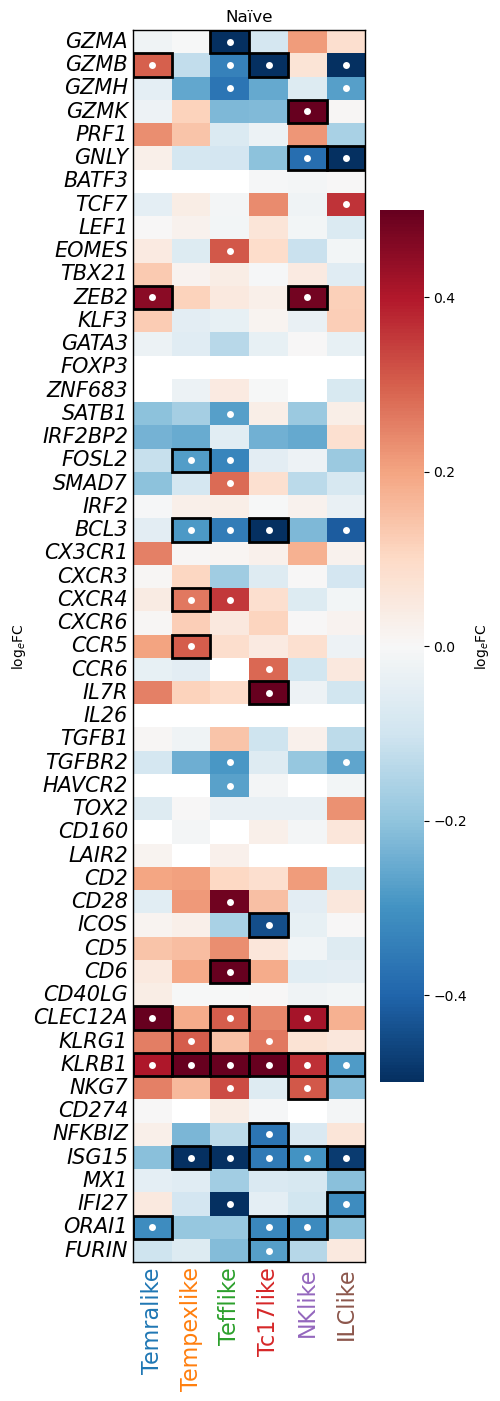

In [25]:
# naive CD8 Supp Fig TNK cell plot
plot_group(allres_FC, issig, "Naïve", show_genes,save=None,flip_direction=True)

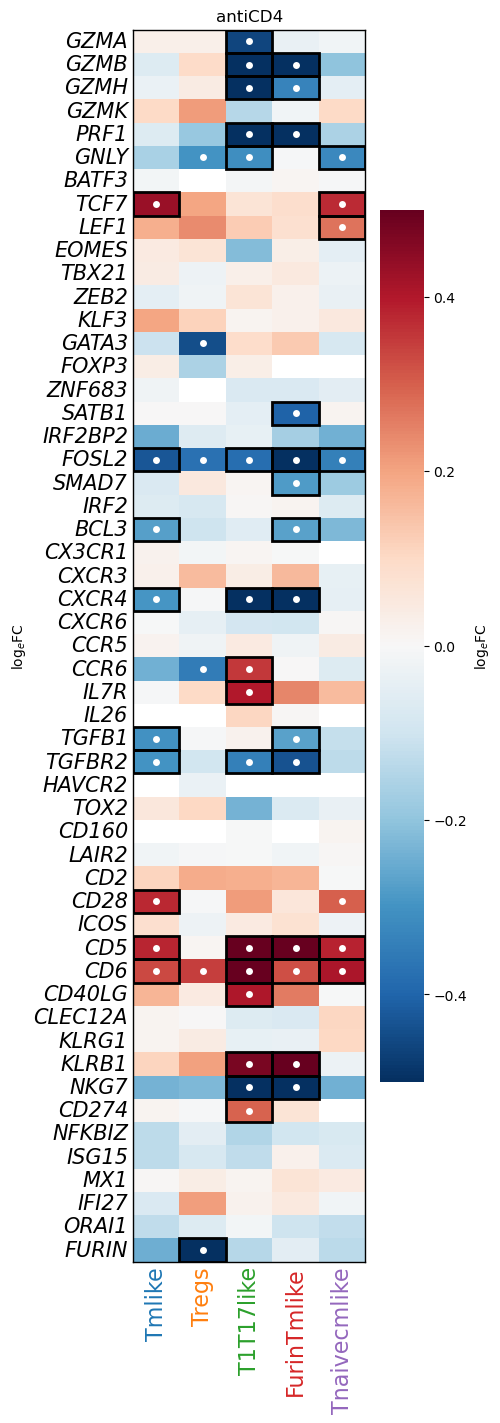

In [31]:
# aCD4 CD4 Supp Fig TNK cell plot
plot_group(allres_FC, issig, "antiCD4", show_genes,save=None,flip_direction=True)


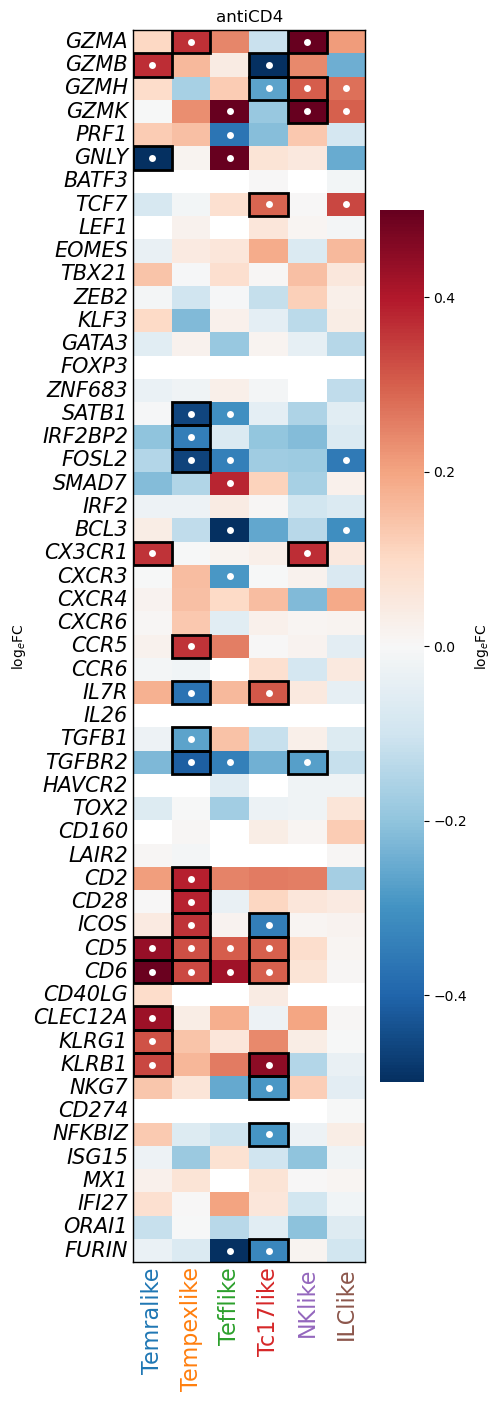

In [26]:
# aCD4 CD8 TNK cell plot
plot_group(allres_FC, issig, "antiCD4", show_genes,save=None,flip_direction=True)


# Supplemental (Figure 4 associated) Extract number of DE genes per condtion

In [7]:
# MAST DE results
file_path = './AllCT.AllPeriod.DE.Merged.csv'
allres = pd.read_csv(file_path, header=[0,1,2], index_col=0)

# reindex columns to specific cell types
allres = allres.reindex(columns=['Tefflike',
 'NKlike',
 'Tc17like',
 'Tnaivecmlike',
 "FurinTmlike",
 'Tempexlike',
 'Temralike',
 'Tregs',
 'ILClike',
 'Tmlike',
 'T1T17like'], level=0)

# define thresholds
q_thresh = 0.05
FC_thresh = 1.3
log_FC_thresh = np.log(FC_thresh)

allres_Q = allres.xs('Q', axis=1, level=2)
allres_FC = allres.xs('logFC', axis=1, level=2)

# determine significant DE genes
issig = (allres_Q < q_thresh) & (allres_FC.abs() > log_FC_thresh)
issig2 = (allres_Q < q_thresh) & (allres_FC < -log_FC_thresh)
issig1 = (allres_Q < q_thresh) & (allres_FC > log_FC_thresh)

# annotate based on directionality (logFC values)
allres['up_in_Naïve'] = issig1.sum(axis=1)
allres['up_in_IgG'] = issig2.sum(axis=1)

# DF w/ significant DE genes
dfT_up = pd.DataFrame(issig1.sum(axis=0), columns=['Naïve'])
dfT_down = pd.DataFrame(issig2.sum(axis=0), columns=['IgG'])

dfT_combined = pd.concat([dfT_up, dfT_down], axis=1).fillna(0).reset_index()
df_naive = dfT_combined[dfT_combined['level_1'] == 'Naïve'].copy()
df_anticd4 = dfT_combined[dfT_combined['level_1'] == 'antiCD4'].copy()

# rename cols
df_naive.columns = ['Celltype', 'Comparison', 'Naïve', 'IgG']
df_anticd4.columns = ['Celltype', 'Comparison', 'antiCD4', 'IgG']

# drop 'comparison' column
df_naive.drop(columns=['Comparison'], inplace=True)
df_anticd4.drop(columns=['Comparison'], inplace=True)

# define cell type order and re-annotate (latex format)
celltype_order = [
    'Temralike', 'Tefflike', 'Tmlike', 'Tnaivecmlike', 'FurinTmlike', 
    'Tempexlike', 'ILClike', 'NKlike', 'T1T17like', 'Tc17like', 'Tregs'
]
celltype_annotations = {
    "Temralike":'$T_{EMRA-like}$',
    "Tefflike":'$T_{Eff-like}$',
    "Tmlike":'$T_{M-like}$',
    "Tnaivecmlike":'$T_{Naive/CM-like}$',
    "FurinTmlike":'FURIN$^{hi}$ $T_{M-like}$',
    "Tempexlike":'GZMK$^{hi}$ $T_{EM/PEX-like}$',
    "ILClike":'ILC-like',
    "NKlike":'NK-like',
    "T1T17like":'T1T17-like',
    "Tc17like":'Tc17-like',
    'Tregs':"Tregs"
}

df_naive['Celltype'] = pd.Categorical(df_naive['Celltype'], categories=celltype_order, ordered=True)
df_anticd4['Celltype'] = pd.Categorical(df_anticd4['Celltype'], categories=celltype_order, ordered=True)

df_naive.sort_values('Celltype', inplace=True)
df_anticd4.sort_values('Celltype', inplace=True)

df_naive['Celltype'] = df_naive['Celltype'].map(celltype_annotations)
df_anticd4['Celltype'] = df_anticd4['Celltype'].map(celltype_annotations)

import matplotlib.patches as patches
def plot_de_genes(df, group1, group2, plot_path, sum_group1, sum_group2):
    df_melted = df.melt(id_vars=['Celltype'], value_vars=[group1, group2], var_name='Group', value_name='Value')
    fig, ax = plt.subplots(figsize=(10, 6))
    fg = sns.barplot(x='Celltype', y='Value', hue='Group', data=df_melted, palette=reinfection_palette, edgecolor='white')
    patch_positions = [i for i in range(len(df['Celltype'])) if i % 2 == 0]
    for pos in patch_positions:
        ax.add_patch(patches.Rectangle((pos - 0.5, ax.get_ylim()[0]), 1, ax.get_ylim()[1] - ax.get_ylim()[0], facecolor="#f0f0f0", edgecolor='none', zorder=-20))
    plt.xticks(rotation=90, size=12)
    fg.yaxis.set_major_locator(plt.MaxNLocator(4))
    ax.yaxis.tick_right()
    plt.yticks(size=12, rotation=0)
    plt.grid(False)
    plt.ylabel("Granuloma: #DE Genes\n (FDR<0.05, logFC>1.3)", size=14)
    plt.xlabel("")
    plt.legend(title="Group", fontsize=12, title_fontsize=14)
    sns.despine(left=False, bottom=False, right=False, top=False)
    for p in fg.patches:
        fg.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points', rotation=90)
    ax.text(len(df['Celltype']) - 0.1, ax.get_ylim()[1] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.15, 
            f'Sum {group1}: {sum_group1}\nSum {group2}: {sum_group2}', fontsize=12, 
            verticalalignment='top', rotation=90)
    plt.savefig(plot_path, bbox_inches='tight', transparent=True, dpi=300)
    plt.show()

sum_naive = df_naive['Naïve'].sum()
sum_igG_naive = df_naive['IgG'].sum()

sum_anticd4 = df_anticd4['antiCD4'].sum()
sum_igG_anticd4 = df_anticd4['IgG'].sum()

os.makedirs('./Reinfection_Figures_For_Publication/Figure4/', exist_ok=True)

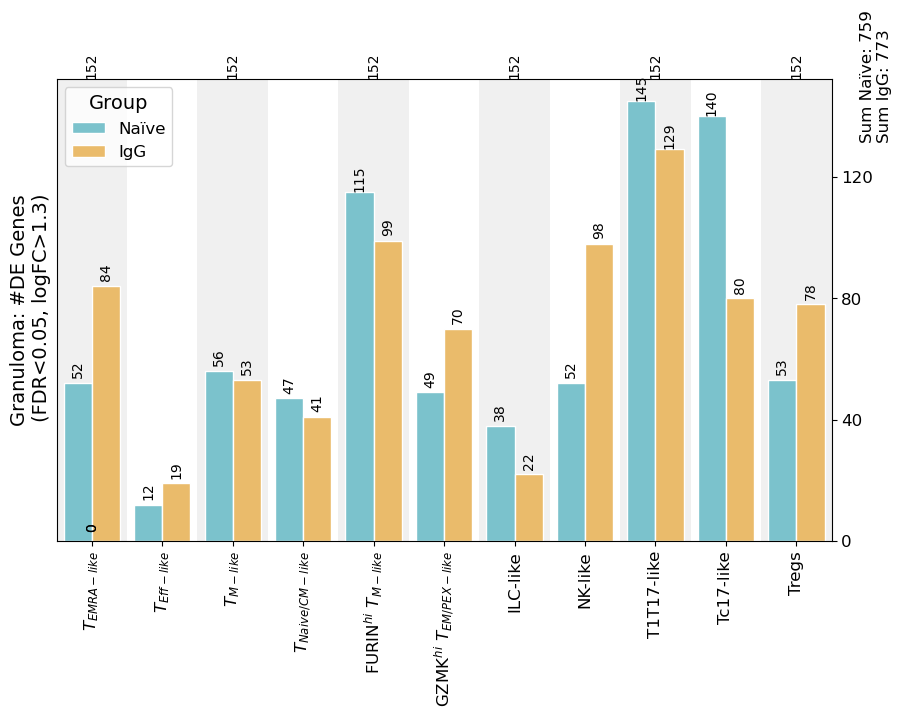

In [8]:
# Plot Naïve vs. IgG DE genes
plot_path_naive_vs_igg = './Reinfection_Figures_For_Publication/Figure4/TNK_Associated_Supplemental_NumDEgenes_NaivevIgG.png'
plot_de_genes(df_naive, 'Naïve', 'IgG', plot_path_naive_vs_igg, sum_naive, sum_igG_naive)

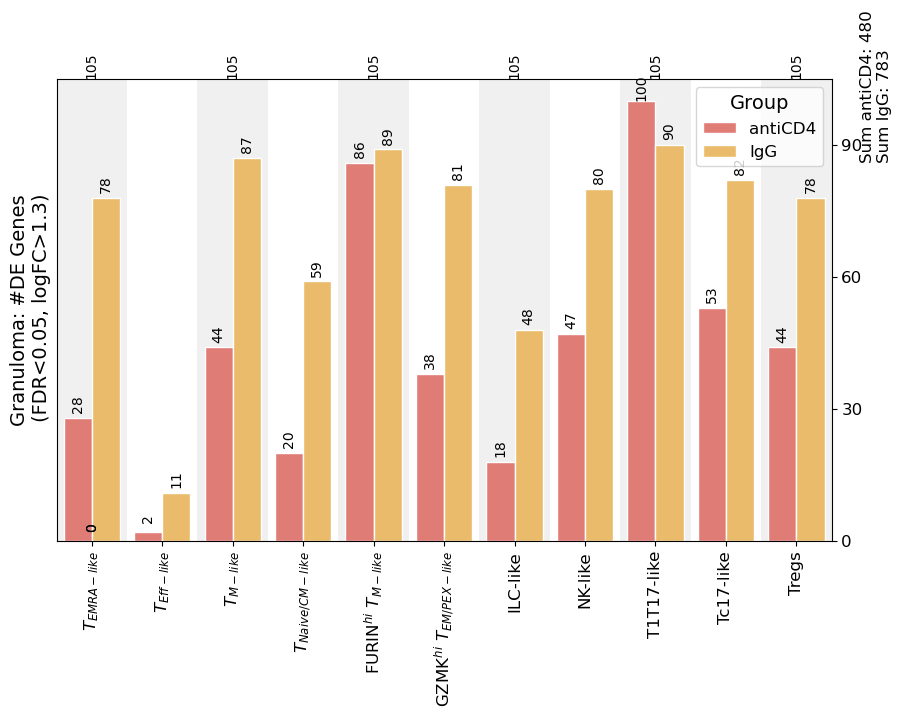

In [9]:
plot_path_anticd4_vs_igg = './Reinfection_Figures_For_Publication/Figure4/TNK_Associated_Supplemental_NumDEgenes_aCD4vIgG.png'
plot_de_genes(df_anticd4, 'antiCD4', 'IgG', plot_path_anticd4_vs_igg, sum_anticd4, sum_igG_anticd4)